# Preprocessing

Image importation and type cast

In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

volume_source = imread("160318 - EQA17-2 LFOV - 47300 cycles_recon.tif")

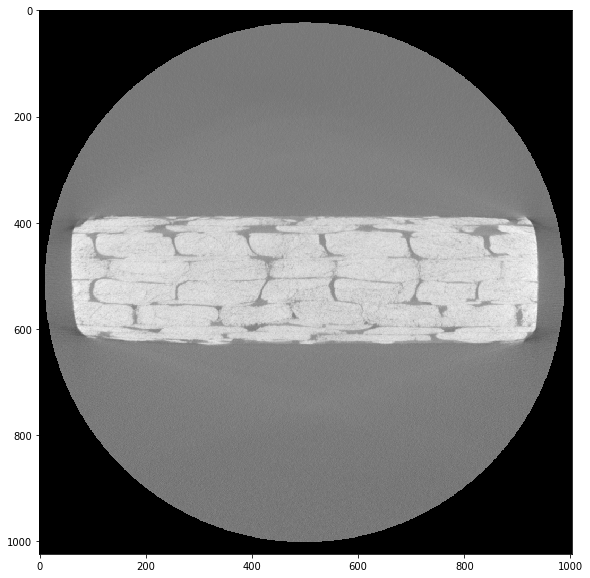

In [5]:
#The firsts and last images of the volume are distorted, for the beginning we take the image in the center only.
volume_source_selection = volume_source[150:850,:,:]

from skimage import img_as_float
volume_typed = img_as_float(volume_source_selection)

img_source = volume_typed[350,:,:]
plt.figure(figsize=(10, 10))
plt.imshow(img_source, cmap=plt.get_cmap('gray'))

## Pre-processing

### Image trimming

We first trim the images to get the interesting part (later, we can try something else, maybe more relevant)

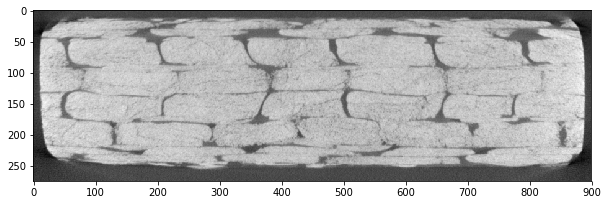

In [6]:
from image_trim import rectangle_trim, rectangle_trim_volume

x1 = 375
x2 = 650
y1 = 50
y2 = 950


volume_trim = rectangle_trim_volume(volume_source_selection, x1, x2, y1, y2)
img_trim = rectangle_trim(img_source, x1, x2, y1, y2)
plt.figure(figsize=(10, 10))
plt.imshow(img_trim, cmap=plt.get_cmap('gray'))

### Image denoising

First linear denoising with a median filter.

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


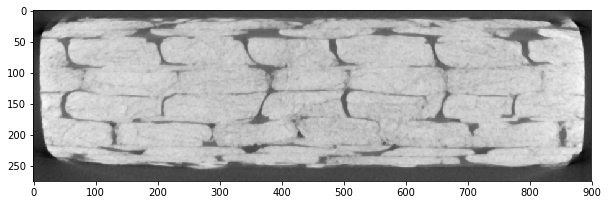

In [65]:
filter_size = 2

from skimage.filters.rank import median
from skimage.morphology import disk
from skimage import img_as_ubyte

img_denoised = median(img_as_ubyte(img_trim), disk(2))
img_denoised_float = img_as_float(img_denoised)
plt.figure(figsize=(10, 10))
plt.imshow(img_denoised, cmap=plt.get_cmap('gray'))

In [46]:
volume_trim_ubyte = img_as_ubyte(volume_trim)

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


0
50
100
150
200
250
300
350
400
450
500
550
600
650


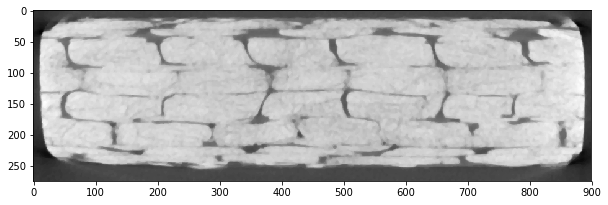

In [83]:
filter_size = 2

from skimage.filters.rank import median
from skimage.morphology import disk

n = volume_trim_ubyte.shape[0]
volume_denoised = volume_trim_ubyte

for i in range(n):
    volume_denoised[i,:,:] = median(volume_trim_ubyte[i,:,:], disk(2))
    if i%50 == 0:
        print(i);
        
volume_denoised_float = img_as_float(volume_denoised)
plt.figure(figsize=(10, 10))
plt.imshow(volume_denoised_float[350,:,:], cmap=plt.get_cmap('gray'))

### Histogram Equalization

We use an adaptative histogram equalization (CLAHE algorithm) to enhance the contrast locally.

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


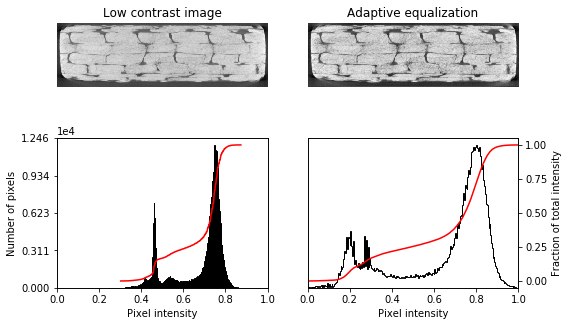

In [70]:
clip_limit = 0.01

import matplotlib
from skimage import exposure

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

img_adapteq = exposure.equalize_adapthist(img_denoised_float, clip_limit= clip_limit)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 2), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 2, 1)
for i in range(1, 2):
    axes[0, i] = fig.add_subplot(2, 2, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 2):
    axes[1, i] = fig.add_subplot(2, 2, 3+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_denoised_float, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 1])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


0
50
100
150
200
250
300
350
400
450
500
550
600
650


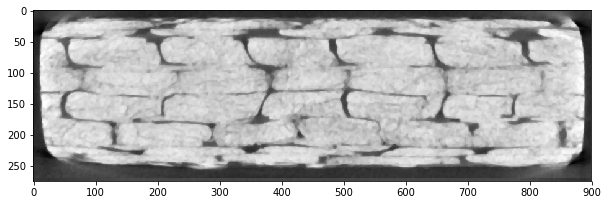

In [94]:
from skimage import exposure
from skimage import img_as_uint

n = volume_denoised.shape[0]
volume_equalized = volume_denoised_float

for i in range(n):
    volume_equalized[i,:,:] = exposure.equalize_adapthist(volume_denoised_float[i,:,:], clip_limit= clip_limit)
    if i%50 == 0:
        print(i);

plt.figure(figsize=(10, 10))
plt.imshow(volume_equalized[350,:,:], cmap=plt.get_cmap('gray'))

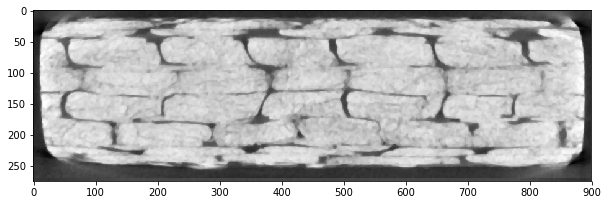

In [97]:
plt.figure(figsize=(10, 10))
plt.imshow(volume_denoised_float[350,:,:], cmap=plt.get_cmap('gray'))

# Image Denoising

As the Equalization operation can increase the noise locally, we reapply denoising.

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


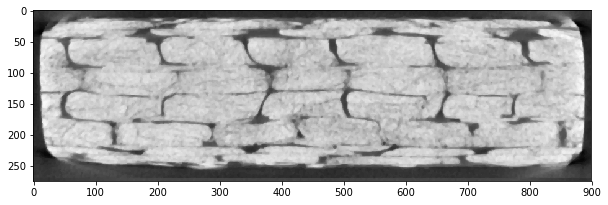

In [103]:
filter_size = 2

from skimage.filters.rank import median
from skimage.morphology import disk
from skimage import img_as_ubyte

img_denoised2 = median(img_as_ubyte(img_adapteq), disk(2))
plt.figure(figsize=(10, 10))
plt.imshow(img_denoised2, cmap=plt.get_cmap('gray'))

In [104]:
volume_equalized_ubyte = img_as_ubyte(volume_equalized)

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


0
50
100
150
200
250
300
350
400
450
500
550
600
650


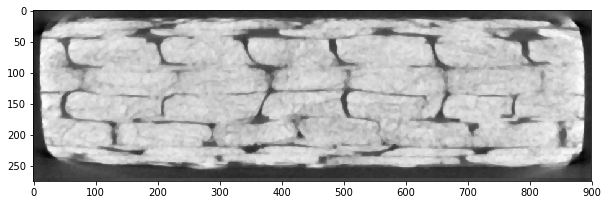

In [105]:
filter_size = 2

from skimage.filters.rank import median
from skimage.morphology import disk

n = volume_trim_ubyte.shape[0]
volume_denoised2 = volume_equalized_ubyte

for i in range(n):
    volume_denoised2[i,:,:] = median(volume_equalized_ubyte[i,:,:], disk(2))
    if i%50 == 0:
        print(i);
        
volume_denoised2_float = img_as_float(volume_denoised2)
plt.figure(figsize=(10, 10))
plt.imshow(volume_denoised2_float[350,:,:], cmap=plt.get_cmap('gray'))

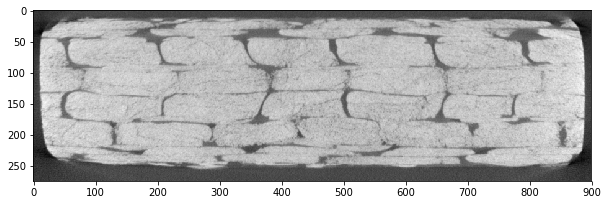

In [107]:
plt.figure(figsize=(10, 10))
plt.imshow(volume_trim[350,:,:], cmap=plt.get_cmap('gray'))

# Save File

In [108]:
from skimage.io import imsave

imsave("Denoised_Equalized_Volume.tif", volume_denoised2_float)

File checking

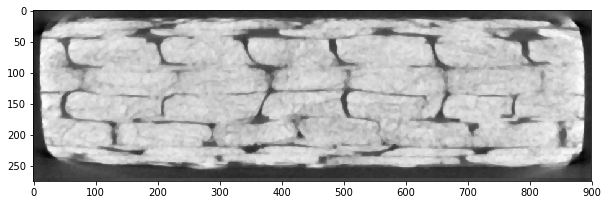

In [109]:
volume_check = imread("Denoised_Equalized_Volume.tif")
img_check = volume_check[350,:,:]
plt.figure(figsize=(10, 10))
plt.imshow(img_check, cmap=plt.get_cmap('gray'))